# Are first babies more likely to be late?

Copyright 2019 Allen Downey

License: [Creative Commons Attribution 4.0 International](http://creativecommons.org/licenses/by/4.0/)

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from utils import values, decorate
from empiricaldist import Surv, Hazard
from empiricaldist import Pmf, Cdf

Load the data:

In [2]:
dfs = []
for i in range(101):
    key = f'nsfg{i}'
    df = pd.read_hdf('nsfg.hdf5', key)
    dfs.append(df)

In [3]:
df0 = dfs[0]
df0.shape

(62539, 6)

In [4]:
def get_lengths(df):
    nosec = (df['pregend1'] == 6)
    single = (df['nbrnaliv'] == 1)

    valid = single & nosec & (df['prglngth'] < 50)

    first = valid & (df['birthord'] == 1)
    other = valid & (df['birthord'] > 1)

    valid_lengths = df.loc[valid, 'prglngth']
    first_lengths = df.loc[first, 'prglngth']
    other_lengths = df.loc[other, 'prglngth']
    
    return first_lengths, other_lengths, valid_lengths

In [5]:
first_lengths, other_lengths, valid_lengths = get_lengths(df)

In [6]:
first_lengths.mean(), other_lengths.mean()

(38.746593099780625, 38.72032611751476)

In [7]:
first_lengths_seq = []
other_lengths_seq = []
valid_lengths_seq = []

for df in dfs:
    first_lengths, other_lengths, valid_lengths = get_lengths(df)
    first_lengths_seq.append(first_lengths)
    other_lengths_seq.append(other_lengths)
    valid_lengths_seq.append(valid_lengths)

In [8]:
def frac_preterm(lengths):
    return np.mean(lengths < 37)

In [9]:
frac_preterm(first_lengths), frac_preterm(other_lengths) 

(0.11965698331449844, 0.09547371380376722)

In [10]:
def apply1(func, seq):
    return [func(x) for x in seq]

In [11]:
frac_preterm_first_seq = apply1(frac_preterm, first_lengths_seq)
frac_preterm_other_seq = apply1(frac_preterm, other_lengths_seq)

In [12]:
np.mean(frac_preterm_first_seq), np.mean(frac_preterm_other_seq)

(0.1196774671614936, 0.09648031664699011)

In [13]:
def diff_means(lengths1, lengths2):
    return lengths1.mean() - lengths2.mean()

In [14]:
diff_means(first_lengths, other_lengths)

0.026266982265866545

In [15]:
def apply2(func, seq1, seq2):
    return [func(x, y) for x,y in zip(seq1, seq2)]

In [16]:
diff_seq = apply2(diff_means, first_lengths_seq, other_lengths_seq)
np.mean(diff_seq)

0.01897035720596225

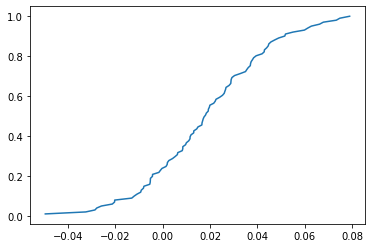

In [17]:
Cdf.from_seq(diff_seq).plot()

In [18]:
np.mean(diff_seq), np.std(diff_seq)

(0.01897035720596225, 0.025379988024462646)

In [19]:
np.mean(diff_seq) * 7 * 24

3.1870200106016586

In [20]:
def diff_means_full_term(lengths1, lengths2):
    lengths1 = [x for x in lengths1 if x>=37]
    lengths2 = [x for x in lengths2 if x>=37]
    return np.mean(lengths1) - np.mean(lengths2)

In [21]:
diff_means_full_term(first_lengths, other_lengths)

0.20347883641327513

In [22]:
diff_seq = apply2(diff_means_full_term, first_lengths_seq, other_lengths_seq)
np.mean(diff_seq)

0.1894229092472438

In [23]:
np.mean(diff_seq) * 7

1.3259603647307068

In [24]:
from scipy.stats import gaussian_kde

def kdeplot(sample, xs, label=None, **options):
    """Use KDE to plot the density function.
    
    sample: NumPy array
    xs: NumPy array
    label: string
    """
    density = gaussian_kde(sample, **options).evaluate(xs)
    plt.plot(xs, density, label=label)
    decorate(ylabel='Relative likelihood')

In [25]:
def make_kde(sample):
    xs = np.linspace(28, 46, 101)
    density = gaussian_kde(sample, bw_method=0.25).evaluate(xs)
    return pd.Series(density, index=xs)

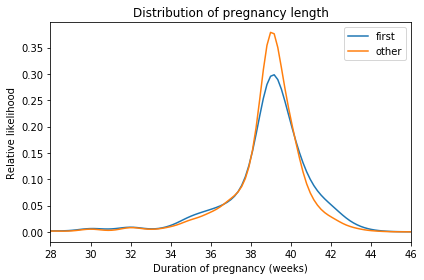

In [26]:
kde_first = make_kde(first_lengths)
kde_first.plot(label='first')

kde_other = make_kde(other_lengths)
kde_other.plot(label='other')

decorate(xlabel='Duration of pregnancy (weeks)',
         ylabel='Relative likelihood',
         title='Distribution of pregnancy length',
         xlim=[28, 46])

In [27]:
kde_first_seq = apply1(make_kde, first_lengths_seq)
kde_other_seq = apply1(make_kde, other_lengths_seq)

In [28]:
def percentile_rows(series_seq, ps):
    """Computes percentiles from aligned series.
    
    series_seq: list of sequences
    ps: cumulative probabilities
    
    returns: Series of x-values, NumPy array with selected rows
    """
    df = pd.concat(series_seq, axis=1).dropna()
    xs = df.index
    array = df.values.transpose()
    array = np.sort(array, axis=0)
    nrows, ncols = array.shape

    ps = np.asarray(ps)
    indices = (ps * nrows).astype(int)
    rows = array[indices]
    return xs, rows

In [29]:
def plot_percentiles(series_seq, label=None, **options):
    ps = [0.05, 0.5, 0.95]
    xs, rows = percentile_rows(series_seq, ps)
    plt.plot(xs, rows[1], alpha=0.6, label=label, **options)
    plt.fill_between(xs, rows[0], rows[2], linewidth=0, alpha=0.4, **options)

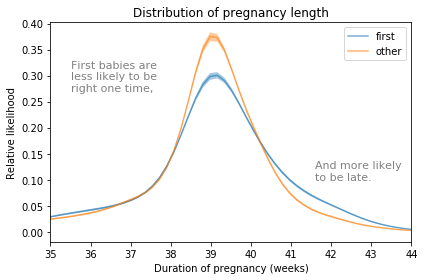

In [30]:
plot_percentiles(kde_first_seq, label='first', color='C0')
plot_percentiles(kde_other_seq, label='other', color='C1')

decorate(title='Distribution of pregnancy length',
         xlabel='Duration of pregnancy (weeks)',
         ylabel='Relative likelihood',
         xlim=[35, 44])

style = dict(size=11, color='gray')

plt.text(35.5, 0.27, 'First babies are\nless likely to be\nright one time,', **style)
plt.text(41.6, 0.10, 'And more likely\nto be late.', **style)

plt.savefig('distribution.png', dpi=150)

In [31]:
surv_first_seq = apply1(Surv.from_seq, first_lengths_seq)
surv_other_seq = apply1(Surv.from_seq, other_lengths_seq)

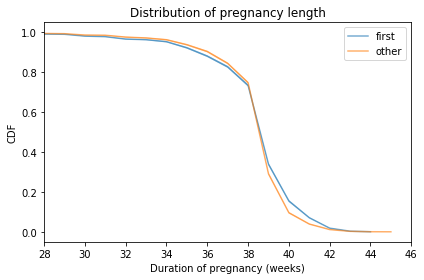

In [32]:
plot_percentiles(surv_first_seq, label='first', color='C0')
plot_percentiles(surv_other_seq, label='other', color='C1')

decorate(title='Distribution of pregnancy length',
         xlabel='Duration of pregnancy (weeks)',
         ylabel='CDF',
         xlim=[28, 46])

In [33]:
def remaining_time(seq, x):
    """Distribution of remaining time, given > x.
    
    seq: sequence
    x: value
    
    returns Pmf
    """
    pmf = Pmf.from_seq(seq - x + 0.5)
    pmf[pmf.qs < 0] = 0
    pmf.normalize()
    return pmf

In [34]:
def func(lengths):
    return remaining_time(lengths, 37).mean()

In [35]:
mrt_first_seq = apply1(func, first_lengths_seq)
mrt_other_seq = apply1(func, other_lengths_seq)
mrt_valid_seq = apply1(func, valid_lengths_seq)

np.mean(mrt_first_seq), np.mean(mrt_other_seq), np.mean(mrt_valid_seq)

(2.9383999148684405, 2.7489770056211955, 2.8351729828665344)

In [36]:
(np.mean(mrt_first_seq) - np.mean(mrt_other_seq)) * 7

1.3259603647307152

In [37]:
def func(lengths):
    return remaining_time(lengths, 39).mean()

In [38]:
mrt_first_seq = apply1(func, first_lengths_seq)
mrt_other_seq = apply1(func, other_lengths_seq)
mrt_valid_seq = apply1(func, valid_lengths_seq)

np.mean(mrt_first_seq), np.mean(mrt_other_seq), np.mean(mrt_valid_seq)

(1.3008138394243656, 1.0894002540045231, 1.185959941297448)

In [39]:
(np.mean(mrt_first_seq) - np.mean(mrt_other_seq)) * 7 * 24

35.517482350533534

In [40]:
def mean_remaining_time(seq):
    """Mean remaining time as a function of age:
    
    seq: sequence
    
    returns: Series that maps from age to mean remaining time
    """
    index = range(37, 44)
    mrt = pd.Series(index=index)
    for x in index:
        mrt[x] = remaining_time(seq, x).mean()
    return mrt

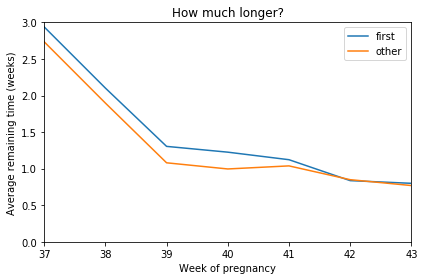

In [41]:
mrt_first = mean_remaining_time(first_lengths)
mrt_first.plot(label='first')

mrt_other = mean_remaining_time(other_lengths)
mrt_other.plot(label='other')

decorate(xlabel='Week of pregnancy',
         ylabel='Average remaining time (weeks)',
         title='How much longer?',
         ylim=[0,3])

In [42]:
mrt_valid_seq = apply1(mean_remaining_time, valid_lengths_seq)

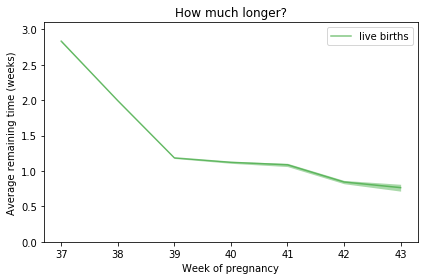

In [43]:
plot_percentiles(mrt_valid_seq, label='live births', color='C2')

decorate(xlabel='Week of pregnancy',
         ylabel='Average remaining time (weeks)',
         title='How much longer?',
         ylim=[0,3.1])

plt.savefig('remaining1.png', dpi=150)

In [44]:
mrt_first_seq = apply1(mean_remaining_time, first_lengths_seq)
mrt_other_seq = apply1(mean_remaining_time, other_lengths_seq)

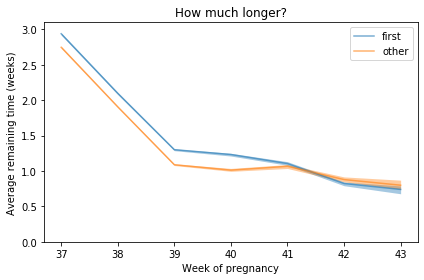

In [45]:
plot_percentiles(mrt_first_seq, label='first', color='C0')
plot_percentiles(mrt_other_seq, label='other', color='C1')

decorate(xlabel='Week of pregnancy',
         ylabel='Average remaining time (weeks)',
         title='How much longer?',
         ylim=[0,3.1])

plt.savefig('remaining2.png', dpi=150)

In [46]:
def prob_this_week(seq):
    """Proability of next week as a function of age:
    
    seq: sequence
    
    returns: Series that maps from age to mean remaining time
    """
    index = range(36, 44)
    prob = pd.Series(index=index)
    for x in index:
        prob[x] = remaining_time(seq, x)[1]
    return prob

In [47]:
prob_this_week(first_lengths)

36    0.0
37    0.0
38    0.0
39    0.0
40    0.0
41    0.0
42    0.0
43    0.0
dtype: float64

In [48]:
def prob_this_week(seq):
    """Proability of next week as a function of age:
    
    seq: sequence
    
    returns: Series that maps from age to mean remaining time
    """
    hazard = Hazard.from_seq(seq)
    index = range(37, 44)
    return hazard.loc[index]

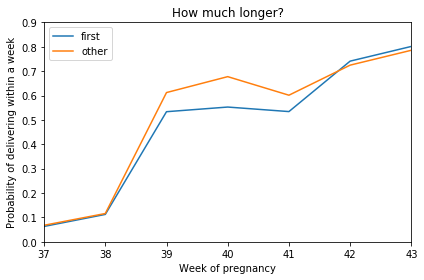

In [49]:
prob_this_week(first_lengths).plot(label='first')
prob_this_week(other_lengths).plot(label='other')

decorate(xlabel='Week of pregnancy',
         ylabel='Probability of delivering within a week',
         title='How much longer?',
         ylim=[0,0.9])

In [50]:
prob_first_seq = apply1(prob_this_week, first_lengths_seq)
prob_other_seq = apply1(prob_this_week, other_lengths_seq)

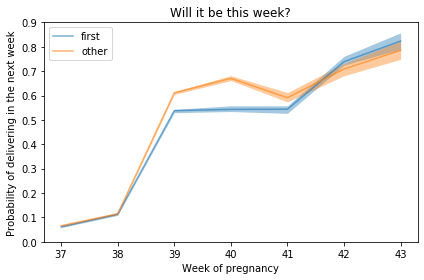

In [51]:
plot_percentiles(prob_first_seq, label='first', color='C0')
plot_percentiles(prob_other_seq, label='other', color='C1')

decorate(xlabel='Week of pregnancy',
         ylabel='Probability of delivering in the next week',
         title='Will it be this week?',
         ylim=[0,0.9])

plt.savefig('probability.png', dpi=150)

In [52]:
def func(seq):
    return Hazard.from_seq(seq)[38]

In [53]:
prob_first_seq = apply1(func, first_lengths_seq)
prob_other_seq = apply1(func, other_lengths_seq)

In [54]:
np.mean(prob_first_seq), np.mean(prob_other_seq)

(0.11284291471567864, 0.1146756069882839)

In [55]:
def func(seq):
    return Hazard.from_seq(seq)[39]

In [56]:
prob_first_seq = apply1(func, first_lengths_seq)
prob_other_seq = apply1(func, other_lengths_seq)

In [57]:
np.mean(prob_first_seq), np.mean(prob_other_seq)

(0.5375026504988264, 0.6107509903666575)